In [15]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    silhouette_score,
    adjusted_rand_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [16]:
# Load test dataset
df = pd.read_csv("test_features.csv")
X_test = df.drop(columns=["label", "en_label"]).values
y_test = df["en_label"].values  # numeric labels — correct for model comparison

# Scale features
scaler = joblib.load("scaler.pkl")
X_test_scaled = scaler.transform(X_test)


label_mapping = df[["en_label", "label"]].drop_duplicates().sort_values("en_label")
en_label_names = label_mapping["label"].tolist() 

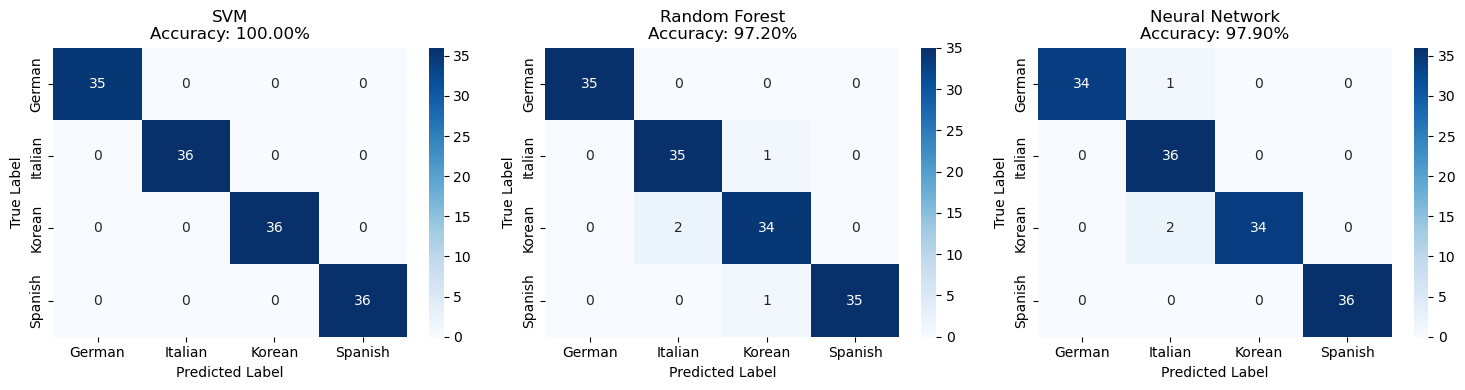


📊 Classification Performance:


,Accuracy,Precision,Recall,F1
SVM,1.000,1.0000,1.000,1.0000
Random Forest,0.972,0.9724,0.972,0.9721
Neural Network,0.979,0.9806,0.979,0.9792


In [17]:
# Model names and files
model_names = ["SVM", "Random Forest", "Neural Network"]
results = {}

plt.figure(figsize=(15, 4))
for i, name in enumerate(model_names, 1):
    # Load model
    model = joblib.load(f"{name.replace(' ', '_')}_model.pkl")
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Metrics (weighted average for multiclass)
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}
    
    # Confusion Matrix
    plt.subplot(1, 3, i)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, annot=True, fmt="d", 
        xticklabels=en_label_names, yticklabels=en_label_names,
        cmap="Blues"
    )
    plt.title(f"{name}\nAccuracy: {acc:.2%}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

plt.tight_layout()
plt.savefig('img/ClassificationPer.png')
plt.show()

# Display metrics table
print("\n📊 Classification Performance:")
display(pd.DataFrame(results).T.round(4))

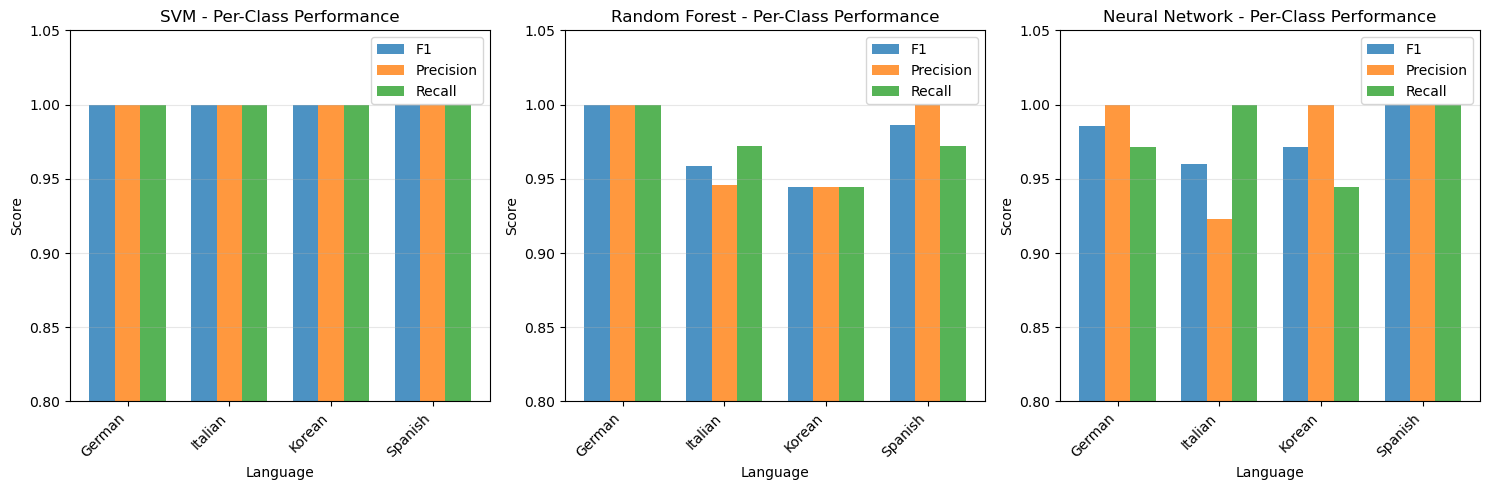

✅ Per-class performance plot saved!


In [18]:
# Plot 1: Per-Class Performance for Each Model
from sklearn.metrics import f1_score, precision_score, recall_score

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, name in enumerate(model_names):
    model = joblib.load(f"{name.replace(' ', '_')}_model.pkl")
    y_pred = model.predict(X_test_scaled)
    
    # Per-class metrics
    f1_per_class = f1_score(y_test, y_pred, average=None)
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    
    x = np.arange(len(en_label_names))
    width = 0.25
    
    axes[idx].bar(x - width, f1_per_class, width, label='F1', alpha=0.8)
    axes[idx].bar(x, precision_per_class, width, label='Precision', alpha=0.8)
    axes[idx].bar(x + width, recall_per_class, width, label='Recall', alpha=0.8)
    
    axes[idx].set_title(f'{name} - Per-Class Performance')
    axes[idx].set_xlabel('Language')
    axes[idx].set_ylabel('Score')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(en_label_names, rotation=45, ha='right')
    axes[idx].legend()
    axes[idx].set_ylim([0.8, 1.05])  # Zoomed to show differences
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('img/classification_per_class.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Per-class performance plot saved!")

🔍 Clustering Evaluation:


📊 K-Means
----------------------------------------------------------------------
  Clusters:          7
  Purity:            0.7063
  Adjusted Rand Idx: 0.3327
  Silhouette Score:  0.2799

📊 GMM
----------------------------------------------------------------------
  Clusters:          7
  Purity:            0.7832
  Adjusted Rand Idx: 0.4202
  Silhouette Score:  0.1903

📊 Agglomerative
----------------------------------------------------------------------
  Clusters:          7
  Purity:            0.7413
  Adjusted Rand Idx: 0.3848
  Silhouette Score:  0.2749

📊 DBSCAN
----------------------------------------------------------------------
  Clusters:          3
  Purity:            0.4545
  Adjusted Rand Idx: 0.0444
  Silhouette Score:  -0.0728

SUMMARY COMPARISON
               n_clusters  Purity     ARI  Silhouette
K-Means               7.0  0.7063  0.3327      0.2799
GMM                   7.0  0.7832  0.4202      0.1903
Agglomerative         7.0  0.7413 

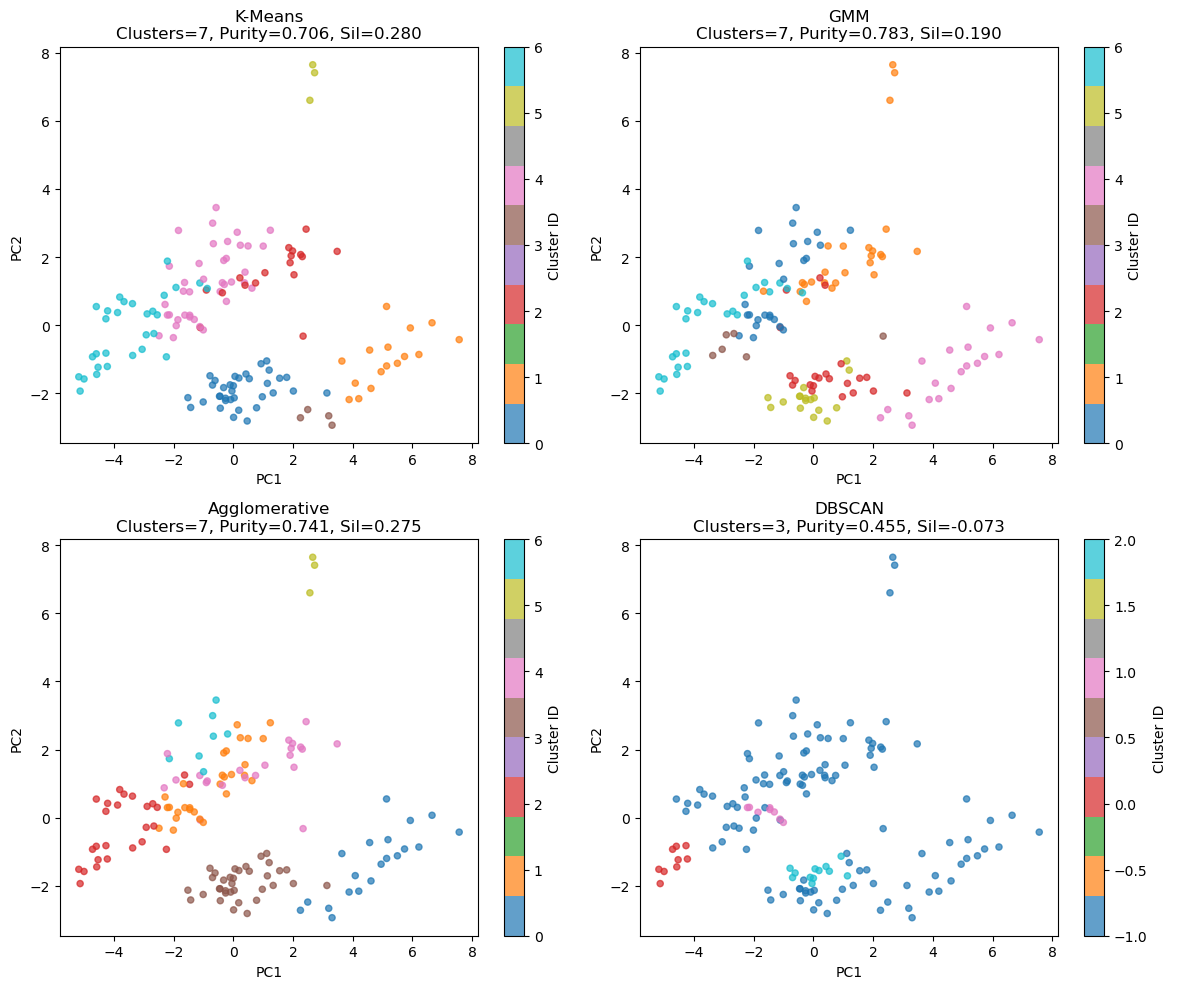


✅ Clustering evaluation complete!


In [19]:
X_full = X_test
X_full_scaled = X_test_scaled
y_true_str = df["label"].values

# Load clustering models and results
clustering_results = joblib.load("clustering_results.pkl")
kmeans = joblib.load("kmeans_model.pkl")
gmm = joblib.load("gmm_model.pkl")
agg = joblib.load("agglomerative_model.pkl")
dbscan = joblib.load("dbscan_model.pkl")
pca_vis = joblib.load("pca_vis.pkl")

models_dict = {
    "K-Means": kmeans,
    "GMM": gmm,
    "Agglomerative": agg,
    "DBSCAN": dbscan
}

true_labels = y_test

# --- Purity ---
def cluster_purity(cluster_labels, true_labels):
    total = len(true_labels)
    purity = 0
    for cluster_id in np.unique(cluster_labels):
        mask = cluster_labels == cluster_id
        cluster_true = true_labels[mask]
        if len(cluster_true) == 0:
            continue
        most_common = np.bincount(cluster_true).max()
        purity += most_common
    return purity / total

print("🔍 Clustering Evaluation:\n")
print("="*70)

eval_results = {}
for method_name, model in models_dict.items():
    cluster_labels = model.fit_predict(X_full_scaled)
    
    purity = cluster_purity(cluster_labels, true_labels)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    sil = silhouette_score(X_full_scaled, cluster_labels) if len(np.unique(cluster_labels)) > 1 else -1
    
    # Get k or n_clusters
    if hasattr(model, 'n_clusters'):
        n_clusters = model.n_clusters
    elif hasattr(model, 'n_components'):
        n_clusters = model.n_components
    elif method_name == "DBSCAN":
        n_clusters = len(np.unique(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    else:
        n_clusters = len(np.unique(cluster_labels))
    
    eval_results[method_name] = {
        "n_clusters": n_clusters,
        "Purity": purity,
        "ARI": ari,
        "Silhouette": sil
    }
    
    print(f"\n📊 {method_name}")
    print("-" * 70)
    print(f"  Clusters:          {n_clusters}")
    print(f"  Purity:            {purity:.4f}")
    print(f"  Adjusted Rand Idx: {ari:.4f}")
    print(f"  Silhouette Score:  {sil:.4f}")

# Summary table
print("\n" + "="*70)
print("SUMMARY COMPARISON")
print("="*70)
summary_df = pd.DataFrame(eval_results).T
print(summary_df.round(4))

# --- Visualize clusters (PCA) ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_full_scaled)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (method_name, model) in enumerate(models_dict.items()):
    cluster_labels = model.fit_predict(X_full_scaled)
    
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="tab10", alpha=0.7, s=20)
    
    n_clusters = eval_results[method_name]["n_clusters"]
    purity_val = eval_results[method_name]["Purity"]
    sil_val = eval_results[method_name]["Silhouette"]
    
    axes[i].set_title(f"{method_name}\nClusters={n_clusters}, Purity={purity_val:.3f}, Sil={sil_val:.3f}")
    axes[i].set_xlabel("PC1")
    axes[i].set_ylabel("PC2")
    plt.colorbar(scatter, ax=axes[i], label="Cluster ID")

plt.tight_layout()
plt.savefig('img/clustering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Clustering evaluation complete!")

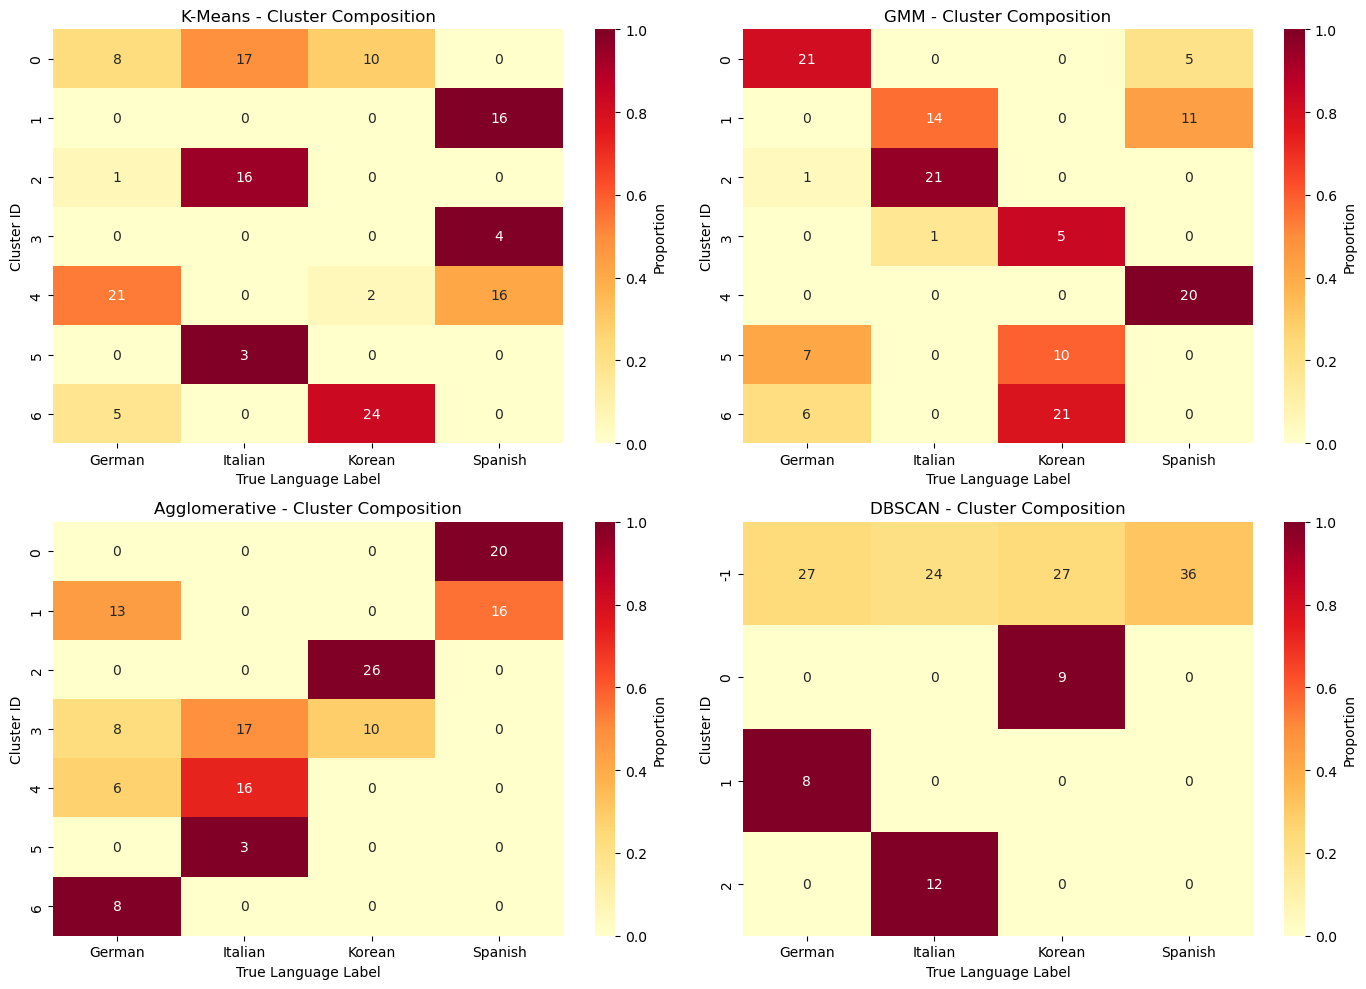

✅ Cluster composition heatmap saved!


In [20]:
# Plot 2: Cluster Composition Heatmap - Which True Labels are in Each Cluster
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, (method_name, model) in enumerate(models_dict.items()):
    cluster_labels = model.fit_predict(X_full_scaled)
    
    # Create composition matrix
    unique_clusters = np.unique(cluster_labels)
    unique_labels = np.unique(y_true_str)
    
    composition = np.zeros((len(unique_clusters), len(unique_labels)))
    
    for c_idx, cluster_id in enumerate(unique_clusters):
        mask = cluster_labels == cluster_id
        cluster_true_labels = y_true_str[mask]
        
        for l_idx, label in enumerate(unique_labels):
            composition[c_idx, l_idx] = np.sum(cluster_true_labels == label)
    
    # Normalize by row for better visualization
    composition_norm = composition / (composition.sum(axis=1, keepdims=True) + 1e-10)
    
    # Plot heatmap
    sns.heatmap(composition_norm, annot=composition.astype(int), fmt='d',
                xticklabels=unique_labels, yticklabels=unique_clusters,
                cmap='YlOrRd', ax=axes[i], cbar_kws={'label': 'Proportion'})
    
    axes[i].set_title(f"{method_name} - Cluster Composition")
    axes[i].set_xlabel("True Language Label")
    axes[i].set_ylabel("Cluster ID")

plt.tight_layout()
plt.savefig('img/clustering_composition.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Cluster composition heatmap saved!")